# TP2 - Informed RRT* Path Planning with Robotino (Holonomic Robot)

**Course**: Mobile Robotics (DCC042)  
**Assignment**: TP2 - Path Planning Algorithms  
**Student**: Daniel Terra Gomes  
**Date**: October 2025

---

## Implementation: Informed RRT* with Holonomic Robot (Robotino)

This notebook implements **Informed RRT*** path planning using the **Robotino** omnidirectional robot in CoppeliaSim.

### Algorithm Overview:
- **Type**: Informed RRT* (sampling-based optimal planner)
- **Optimality**: Asymptotically optimal
- **Key Feature**: Ellipsoidal informed sampling for faster convergence
- **Robot**: Holonomic (no kinematic constraints)

### Robot Specifications:
- **Type**: Holonomic (3 omnidirectional wheels at 120°)
- **Wheelbase**: L = 0.135 m
- **Wheel radius**: r = 0.040 m
- **Control**: Proportional velocity control

---

## 1. Setup and Imports

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import binary_dilation
import time

# Add utils to path
sys.path.append('./utils')

# Import custom modules
from robotino_controller import RobotinoController
from informed_rrt_star_planner import InformedRRTStarPlanner
import common_utils as utils

# Reload for development
import importlib
importlib.reload(sys.modules['robotino_controller'])
importlib.reload(sys.modules['informed_rrt_star_planner'])
importlib.reload(sys.modules['common_utils'])

from robotino_controller import RobotinoController
from informed_rrt_star_planner import InformedRRTStarPlanner
from common_utils import wait_for_user_input

print("  - Robotino controller (holonomic 3-wheel)")
print("  - Informed RRT* planner (optimal sampling-based)")
print("  - Utilities for coordinate transformation")

  - Robotino controller (holonomic 3-wheel)
  - Informed RRT* planner (optimal sampling-based)
  - Utilities for coordinate transformation


## 2. Configuration Parameters

In [2]:
# World parameters
WORLD_WIDTH = 10.0
WORLD_HEIGHT = 10.0

# Robot dimensions
ROBOT_RADIUS = 0.10
SAFETY_MARGIN = 0.10  # Increased from 0.05 to prevent wall collisions
EFFECTIVE_RADIUS = ROBOT_RADIUS + SAFETY_MARGIN  # 0.20m total C-space dilation

# Informed RRT* parameters
MAX_ITERATIONS = 2000  # Reduced from 3000 for faster convergence
STEP_SIZE = 0.4  # Slightly smaller for more precise paths
GOAL_SAMPLE_RATE = 0.10  # Increased from 0.05 for faster goal finding
SEARCH_RADIUS = 1.5  # Reduced from 2.0 for more focused rewiring
GOAL_THRESHOLD = 0.3
RANDOM_SEED = 42
EARLY_TERMINATION = 300  # Stop if no improvement after 300 iterations

# Control parameters
ROBOT_SPEED = 0.5
POSITION_THRESHOLD = 0.15

print(f"Configuration:")
print(f"  Robot: radius={ROBOT_RADIUS}m, effective={EFFECTIVE_RADIUS}m")
print(f"  RRT*: iterations={MAX_ITERATIONS}, step={STEP_SIZE}m")
print(f"  RRT*: search_radius={SEARCH_RADIUS}m, goal_threshold={GOAL_THRESHOLD}m")
print(f"  RRT*: goal_sample_rate={GOAL_SAMPLE_RATE}, early_termination={EARLY_TERMINATION}")

Configuration:
  Robot: radius=0.1m, effective=0.2m
  RRT*: iterations=2000, step=0.4m
  RRT*: search_radius=1.5m, goal_threshold=0.3m
  RRT*: goal_sample_rate=0.1, early_termination=300


---

# Experiment 1: Paredes Map (Corridor Environment)

First experiment using the corridor map to test Informed RRT* in a structured environment.

---

## 3. Connect to CoppeliaSim

In [3]:
# Create controller
controller = RobotinoController()

# Connect to CoppeliaSim
if not controller.connect():
    raise Exception("Failed to connect to CoppeliaSim")

# Initialize scene
if not controller.initialize_scene():
    raise Exception("Failed to initialize scene")

print("✓ Connected to CoppeliaSim")
print(f"  - Robot handle: {controller.robot_handle}")
print(f"  - Goal handle: {controller.goal_handle}")
print(f"  - Robot type: Robotino (holonomic)")

Connecting to CoppeliaSim...
✓ Connected to CoppeliaSim
✓ Robot found: '/robotino' (handle: 15)
✓ Goal found: '/Goal' (handle: 13)
✓ Found 3 wheel joints for omnidirectional control
✓ Connected to CoppeliaSim
  - Robot handle: 15
  - Goal handle: 13
  - Robot type: Robotino (holonomic)


## 4. Query Terrain Dimensions

In [4]:
# Query terrain dimensions
print("\nScene Analysis:")

try:
    all_objects = controller.sim.getObjectsInTree(controller.sim.handle_scene, controller.sim.object_shape_type, 0)

    terrain_found = False
    for obj_handle in all_objects:
        try:
            obj_name = controller.sim.getObjectAlias(obj_handle)
            if 'terrain' in obj_name.lower() or 'heightfield' in obj_name.lower():
                min_x = controller.sim.getObjectFloatParam(obj_handle, controller.sim.objfloatparam_objbbox_min_x)
                max_x = controller.sim.getObjectFloatParam(obj_handle, controller.sim.objfloatparam_objbbox_max_x)
                min_y = controller.sim.getObjectFloatParam(obj_handle, controller.sim.objfloatparam_objbbox_min_y)
                max_y = controller.sim.getObjectFloatParam(obj_handle, controller.sim.objfloatparam_objbbox_max_y)

                terrain_width = max_x - min_x
                terrain_height = max_y - min_y

                print(f"✓ Detected {obj_name}: {terrain_width:.2f}m × {terrain_height:.2f}m")
                terrain_found = True
                break
        except:
            continue

    if not terrain_found:
        terrain_width = 10.0
        terrain_height = 10.0
        print(f"No terrain detected, using default: {terrain_width:.2f}m × {terrain_height:.2f}m")

except Exception as e:
    terrain_width = 10.0
    terrain_height = 10.0
    print(f"Error detecting terrain: {e}")
    print(f"   Using default: {terrain_width:.2f}m × {terrain_height:.2f}m")

# Store actual terrain dimensions
ACTUAL_TERRAIN_WIDTH = terrain_width
ACTUAL_TERRAIN_HEIGHT = terrain_height

# Create scene-specific transforms
def sim_to_map_1(x, y):
    map_x = x + (ACTUAL_TERRAIN_WIDTH / 2.0)
    map_y = y + (ACTUAL_TERRAIN_HEIGHT / 2.0)
    return (map_x, map_y)

def map_to_sim_1(x, y):
    sim_x = x - (ACTUAL_TERRAIN_WIDTH / 2.0)
    sim_y = y - (ACTUAL_TERRAIN_HEIGHT / 2.0)
    return (sim_x, sim_y)

print(f"✓ Transforms created for {ACTUAL_TERRAIN_WIDTH:.1f}m × {ACTUAL_TERRAIN_HEIGHT:.1f}m terrain")


Scene Analysis:
✓ Detected Terrain_Heightfield: 10.00m × 7.67m
✓ Transforms created for 10.0m × 7.7m terrain


## 5. Get Robot and Goal Positions

In [5]:
# Get robot pose
robot_x, robot_y, robot_theta = controller.get_robot_pose_2d()
robot_map_x, robot_map_y = sim_to_map_1(robot_x, robot_y)

print("Experiment 1 - Robot Status:")
print(f"   Position (CoppeliaSim): ({robot_x:.2f}, {robot_y:.2f})")
print(f"   Orientation: {np.degrees(robot_theta):.1f}°")
print(f"   Position (Map frame): ({robot_map_x:.2f}, {robot_map_y:.2f})")

# Get goal position
goal_pos = controller.get_goal_position()
goal_map_x, goal_map_y = sim_to_map_1(goal_pos[0], goal_pos[1])

print(f"\nGoal Position:")
print(f"   Position (CoppeliaSim): ({goal_pos[0]:.2f}, {goal_pos[1]:.2f})")
print(f"   Position (Map frame): ({goal_map_x:.2f}, {goal_map_y:.2f})")

Experiment 1 - Robot Status:
   Position (CoppeliaSim): (-3.68, -2.85)
   Orientation: -0.0°
   Position (Map frame): (1.33, 0.99)

Goal Position:
   Position (CoppeliaSim): (3.10, 2.40)
   Position (Map frame): (8.10, 6.24)


## 6. Load and Process Paredes Map

✓ Paredes Map loaded: (500, 650) pixels
  - Physical size: 10.0m x 7.7m
  - C-space dilation: 12 pixels (0.200m)


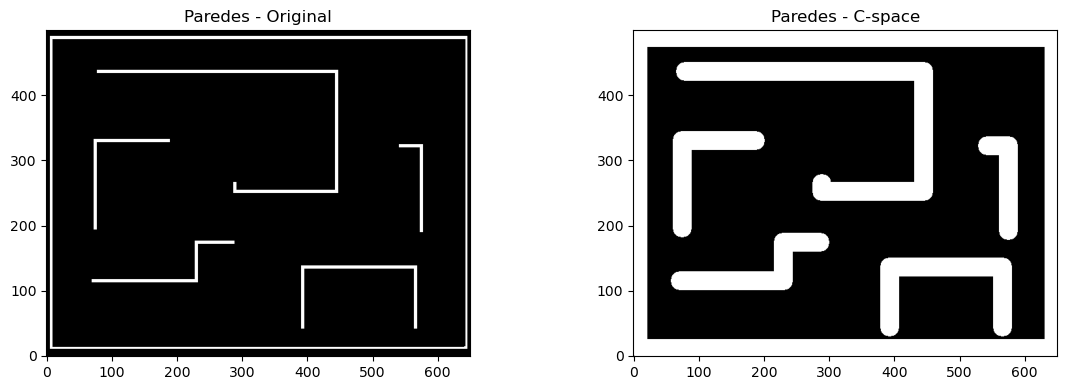

In [6]:
# Load paredes map
map_path_1 = "mapas/paredes.png"
mapa_img_1 = Image.open(map_path_1).convert('L')
mapa_raw_1 = np.array(mapa_img_1)

# Normalize: 0=free, 1=obstacle
mapa_original_1 = 1.0 - (mapa_raw_1 / 255.0)

# Apply C-space transformation
radius_pixels_1 = int((EFFECTIVE_RADIUS / ACTUAL_TERRAIN_WIDTH) * mapa_original_1.shape[1])
y, x = np.ogrid[-radius_pixels_1:radius_pixels_1+1, -radius_pixels_1:radius_pixels_1+1]
structure_1 = (x**2 + y**2 <= radius_pixels_1**2).astype(int)
mapa_1 = binary_dilation(mapa_original_1 > 0.5, structure=structure_1).astype(float)

print(f"✓ Paredes Map loaded: {mapa_1.shape} pixels")
print(f"  - Physical size: {ACTUAL_TERRAIN_WIDTH:.1f}m x {ACTUAL_TERRAIN_HEIGHT:.1f}m")
print(f"  - C-space dilation: {radius_pixels_1} pixels ({EFFECTIVE_RADIUS:.3f}m)")

# Visualize
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(mapa_original_1, cmap='gray', origin='lower')
plt.title('Paredes - Original')
plt.subplot(1, 2, 2)
plt.imshow(mapa_1, cmap='gray', origin='lower')
plt.title('Paredes - C-space')
plt.tight_layout()
plt.show()

## 7. Plan Path with Informed RRT*

In [7]:
# Initialize planner
planner_1 = InformedRRTStarPlanner(
    mapa=mapa_1,
    world_width=ACTUAL_TERRAIN_WIDTH,
    world_height=ACTUAL_TERRAIN_HEIGHT,
    robot_radius=ROBOT_RADIUS,
    safety_margin=SAFETY_MARGIN
)

# Define start and goal
start_map_1 = (robot_map_x, robot_map_y)
goal_map_1 = (goal_map_x, goal_map_y)

print(f"\nPlanning in Paredes:")
print(f"   Start: {start_map_1}")
print(f"   Goal:  {goal_map_1}")

# Run Informed RRT*
import time
start_time_1 = time.time()

path_map_1 = planner_1.plan(
    start=start_map_1,
    goal=goal_map_1,
    max_iterations=MAX_ITERATIONS,
    step_size=STEP_SIZE,
    goal_sample_rate=GOAL_SAMPLE_RATE,
    search_radius=SEARCH_RADIUS,
    goal_threshold=GOAL_THRESHOLD,
    seed=RANDOM_SEED,
    early_termination_iterations=EARLY_TERMINATION
)

elapsed_time_1 = time.time() - start_time_1

if path_map_1:
    path_array_1 = np.array(path_map_1)
    path_length_1 = np.sum(np.sqrt(np.sum(np.diff(path_array_1, axis=0)**2, axis=1)))

    print(f"\n✓ Path found!")
    print(f"   Waypoints: {len(path_map_1)}")
    print(f"   Length: {path_length_1:.2f} m")
    print(f"   Planning time: {elapsed_time_1:.2f} s")
else:
    print("\n✗ No path found!")

Informed RRT* Planner initialized:
  - Robot radius: 0.10 m
  - Safety margin: 0.10 m
  - Effective radius: 0.20 m
  - World size: 10.000000000000014 x 7.674418604651172 m

Planning in Paredes:
   Start: (1.3250000000000068, 0.9872093023255872)
   Goal:  (8.100000000000009, 6.237209302325587)

Planning with Informed RRT*:
  Start: (1.3250000000000068, 0.9872093023255872)
  Goal:  (8.100000000000009, 6.237209302325587)

INFORMED RRT* PATH PLANNING - Optimized Pipeline

  First solution found at iteration 143
  - Initial cost: 9.21 meters
  - Switching to informed sampling...

  Improved solution at iteration 201
  - New cost: 9.11 meters (improved by 0.100m)


  Early termination: 300 iterations without improvement
  Stopping at iteration 653/2000

✓ Planning SUCCESSFUL
  - Waypoints: 10
  - Final cost: 9.11 meters
  - Tree nodes: 402
  - Iterations used: 653/2000
  - First solution at: iteration 143
  - Last improvement at: iteration 201

✓ Path found!
   Waypoints: 10
   Length: 9.10 

## 8. Visualize Path and Tree

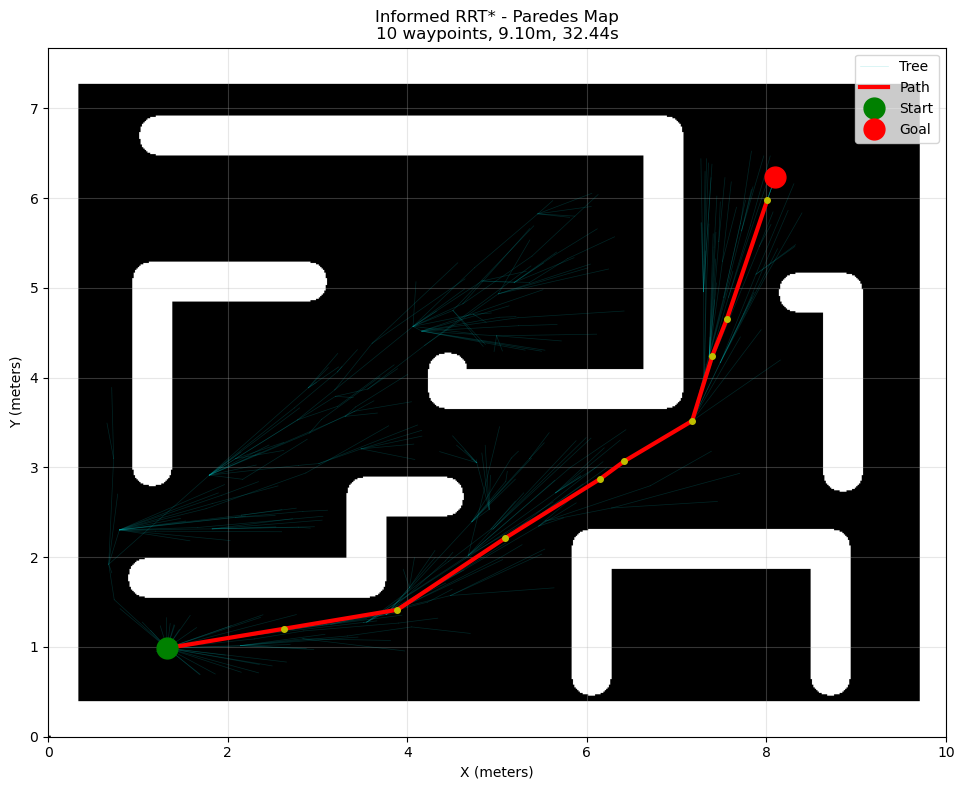

In [8]:
if path_map_1:
    fig, ax = plt.subplots(figsize=(12, 8))

    # Show map
    ax.imshow(mapa_1, cmap='gray', origin='lower',
             extent=[0, ACTUAL_TERRAIN_WIDTH, 0, ACTUAL_TERRAIN_HEIGHT])

    # Draw tree edges
    for node in planner_1.nodes:
        if node.parent:
            ax.plot([node.x, node.parent.x], [node.y, node.parent.y],
                   'c-', alpha=0.2, linewidth=0.5, label='Tree' if node == planner_1.nodes[1] else '')

    # Draw path
    path_x = [p[0] for p in path_map_1]
    path_y = [p[1] for p in path_map_1]
    ax.plot(path_x, path_y, 'r-', linewidth=3, label='Path')
    ax.plot(path_x, path_y, 'yo', markersize=4)

    # Mark start and goal
    ax.plot(start_map_1[0], start_map_1[1], 'go', markersize=15, label='Start')
    ax.plot(goal_map_1[0], goal_map_1[1], 'ro', markersize=15, label='Goal')

    ax.set_xlim(0, ACTUAL_TERRAIN_WIDTH)
    ax.set_ylim(0, ACTUAL_TERRAIN_HEIGHT)
    ax.set_xlabel('X (meters)')
    ax.set_ylabel('Y (meters)')
    ax.set_title(f'Informed RRT* - Paredes Map\n{len(path_map_1)} waypoints, {path_length_1:.2f}m, {elapsed_time_1:.2f}s')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 9. Execute Path in CoppeliaSim

In [9]:
if path_map_1:
    # Convert path to CoppeliaSim coordinates
    path_sim_1 = [map_to_sim_1(x, y) for x, y in path_map_1]

    print(f"   Total waypoints: {len(path_sim_1)}")
    print(f"   Path length: {path_length_1:.2f} m")
    print(f"   Speed: {ROBOT_SPEED}")
    print(f"   Position tolerance: {POSITION_THRESHOLD} m")
    print(f"   Using holonomic proportional control (no forced orientation)")

    # Start simulation
    controller.start_simulation()
    time.sleep(0.5)

    try:
        # Execute path
        success = controller.move_along_path(
            path_sim_1,
            speed=ROBOT_SPEED,
            tolerance=POSITION_THRESHOLD,
            visualize=True
        )

        if success:
            # Get final pose
            final_x, final_y, final_theta = controller.get_robot_pose_2d()
            final_error = np.sqrt((final_x - goal_pos[0])**2 + (final_y - goal_pos[1])**2)

            print(f"\n✓ Paredes execution completed!")
            print(f"   Final position: ({final_x:.2f}, {final_y:.2f})")
            print(f"   Final orientation: {np.degrees(final_theta):.1f}°")
            print(f"   Final error: {final_error:.3f} m")
        else:
            print(f"\nPath execution failed!")

    except Exception as e:
        print(f"\nError during execution: {e}")

    finally:
        # Stop simulation
        controller.stop_simulation()
        print("\n✓ Simulation stopped")

   Total waypoints: 10
   Path length: 9.10 m
   Speed: 0.5
   Position tolerance: 0.15 m
   Using holonomic proportional control (no forced orientation)

🚀 Starting path following (10 waypoints)...
   Using holonomic proportional control
  → Waypoint 1/10: (-3.68, -2.85)
    ✓ Waypoint 1 (error: 0.002m, theta: 0.4°)
  → Waypoint 2/10: (-2.37, -2.63)
    ✓ Waypoint 2 (error: 0.146m, theta: -1.5°)
  → Waypoint 3/10: (-1.11, -2.42)
    ✓ Waypoint 3 (error: 0.145m, theta: -4.9°)
  → Waypoint 4/10: (0.09, -1.63)
    ✓ Waypoint 4 (error: 0.146m, theta: -14.9°)
  → Waypoint 5/10: (1.15, -0.96)
    ✓ Waypoint 5 (error: 0.146m, theta: -19.2°)
  → Waypoint 6/10: (1.41, -0.77)
    ✓ Waypoint 6 (error: 0.148m, theta: -18.7°)
  → Waypoint 7/10: (2.17, -0.32)
    ✓ Waypoint 7 (error: 0.141m, theta: -19.5°)
  → Waypoint 8/10: (2.40, 0.41)
    ✓ Waypoint 8 (error: 0.147m, theta: -17.8°)
  → Waypoint 9/10: (2.56, 0.82)
    ✓ Waypoint 9 (error: 0.145m, theta: -17.0°)
  → Waypoint 10/10: (3.01, 2.14)
  

---

# Experiment 2: Cave Map (Open Space with Islands)

Second experiment using the cave map to test Informed RRT* in a more open environment.

---

In [10]:
print("\n" + "="*60)
print("Experiment 2 - Cave Map")

print("="*60)

wait_for_user_input("Pressione Enter após abrir Cave Map)...")


Experiment 2 - Cave Map


## 10. Reconnect for Experiment 2

In [19]:
# Reconnect to CoppeliaSim
controller = RobotinoController()
if not controller.connect():
    raise Exception("Failed to connect")
if not controller.initialize_scene():
    raise Exception("Failed to initialize")

print("✓ Connected to CoppeliaSim for Experiment 2")

Connecting to CoppeliaSim...
✓ Connected to CoppeliaSim
✓ Robot found: '/robotino' (handle: 16)
✓ Goal found: '/Goal' (handle: 14)
✓ Found 3 wheel joints for omnidirectional control
✓ Connected to CoppeliaSim for Experiment 2


## 11. Query Cave Scene Dimensions

In [20]:
# Query cave terrain dimensions
print("\nCave Scene Analysis:")

try:
    all_objects_2 = controller.sim.getObjectsInTree(controller.sim.handle_scene, controller.sim.object_shape_type, 0)

    terrain_found = False
    for obj_handle in all_objects_2:
        try:
            obj_name = controller.sim.getObjectAlias(obj_handle)
            if 'terrain' in obj_name.lower() or 'heightfield' in obj_name.lower():
                min_x_2 = controller.sim.getObjectFloatParam(obj_handle, controller.sim.objfloatparam_objbbox_min_x)
                max_x_2 = controller.sim.getObjectFloatParam(obj_handle, controller.sim.objfloatparam_objbbox_max_x)
                min_y_2 = controller.sim.getObjectFloatParam(obj_handle, controller.sim.objfloatparam_objbbox_min_y)
                max_y_2 = controller.sim.getObjectFloatParam(obj_handle, controller.sim.objfloatparam_objbbox_max_y)

                terrain_width_2 = max_x_2 - min_x_2
                terrain_height_2 = max_y_2 - min_y_2

                print(f"✓ Detected {obj_name}: {terrain_width_2:.2f}m × {terrain_height_2:.2f}m")
                terrain_found = True
                break
        except:
            continue

    if not terrain_found:
        terrain_width_2 = 10.0
        terrain_height_2 = 10.0
        print(f"No terrain detected, using default: {terrain_width_2:.2f}m × {terrain_height_2:.2f}m")

except Exception as e:
    terrain_width_2 = 10.0
    terrain_height_2 = 10.0
    print(f"   Using default: {terrain_width_2:.2f}m × {terrain_height_2:.2f}m")

# Create transforms for cave
def sim_to_map_cave(x, y):
    map_x = x + (terrain_width_2 / 2.0)
    map_y = y + (terrain_height_2 / 2.0)
    return (map_x, map_y)

def map_to_sim_cave(x, y):
    sim_x = x - (terrain_width_2 / 2.0)
    sim_y = y - (terrain_height_2 / 2.0)
    return (sim_x, sim_y)

print(f"Transforms created for {terrain_width_2:.1f}m × {terrain_height_2:.1f}m terrain")


Cave Scene Analysis:
✓ Detected Terrain_Heightfield: 10.00m × 10.00m
Transforms created for 10.0m × 10.0m terrain


## 12. Get Positions for Cave Scene

In [21]:
# Get robot pose
robot_x_2, robot_y_2, robot_theta_2 = controller.get_robot_pose_2d()
robot_map_x_2, robot_map_y_2 = sim_to_map_cave(robot_x_2, robot_y_2)

print(f"   Position (CoppeliaSim): ({robot_x_2:.2f}, {robot_y_2:.2f})")
print(f"   Orientation: {np.degrees(robot_theta_2):.1f}°")
print(f"   Position (Map frame): ({robot_map_x_2:.2f}, {robot_map_y_2:.2f})")

# Get goal
goal_pos_2 = controller.get_goal_position()
goal_map_x_2, goal_map_y_2 = sim_to_map_cave(goal_pos_2[0], goal_pos_2[1])

print(f"   Position (CoppeliaSim): ({goal_pos_2[0]:.2f}, {goal_pos_2[1]:.2f})")
print(f"   Position (Map frame): ({goal_map_x_2:.2f}, {goal_map_y_2:.2f})")

   Position (CoppeliaSim): (-4.63, -4.67)
   Orientation: -0.0°
   Position (Map frame): (0.38, 0.33)
   Position (CoppeliaSim): (4.15, 2.40)
   Position (Map frame): (9.15, 7.40)


## 13. Load and Process Cave Map

Cave Map loaded: (500, 500) pixels
  - Physical size: 10.0m x 10.0m
  - Cave safety margin: 0.200m (2x standard)
  - Cave effective radius: 0.250m
  - C-space dilation: 12 pixels (0.250m)


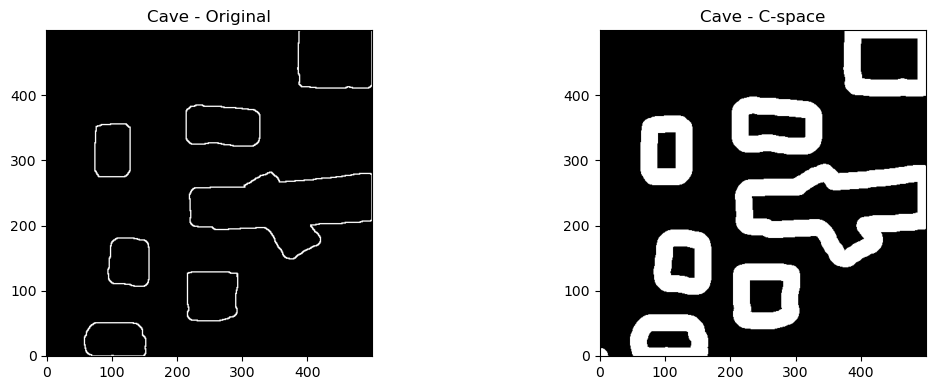

In [22]:
# Load cave map
map_path_2 = "mapas/cave.png"
mapa_img_2 = Image.open(map_path_2).convert('L')
mapa_raw_2 = np.array(mapa_img_2)

# Normalize
mapa_original_2 = 1.0 - (mapa_raw_2 / 255.0)

# Apply C-space transformation with 2x safety margin for cave
# Cave environment: Use double safety margin (0.20m instead of 0.10m)
CAVE_SAFETY_MARGIN = SAFETY_MARGIN * 2.0  # 0.20m (2x larger for cave)
CAVE_EFFECTIVE_RADIUS = (ROBOT_RADIUS + CAVE_SAFETY_MARGIN) / 1.2  # 0.25m total

# C-space dilation with cave-specific effective radius
radius_pixels_2 = int((CAVE_EFFECTIVE_RADIUS / terrain_width_2) * mapa_original_2.shape[1])
y2, x2 = np.ogrid[-radius_pixels_2:radius_pixels_2+1, -radius_pixels_2:radius_pixels_2+1]
structure_2 = (x2**2 + y2**2 <= radius_pixels_2**2).astype(int)
mapa_2 = binary_dilation(mapa_original_2 > 0.5, structure=structure_2).astype(float)

print(f"Cave Map loaded: {mapa_2.shape} pixels")
print(f"  - Physical size: {terrain_width_2:.1f}m x {terrain_height_2:.1f}m")
print(f"  - Cave safety margin: {CAVE_SAFETY_MARGIN:.3f}m (2x standard)")
print(f"  - Cave effective radius: {CAVE_EFFECTIVE_RADIUS:.3f}m")
print(f"  - C-space dilation: {radius_pixels_2} pixels ({CAVE_EFFECTIVE_RADIUS:.3f}m)")

# Visualize
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(mapa_original_2, cmap='gray', origin='lower')
plt.title('Cave - Original')
plt.subplot(1, 2, 2)
plt.imshow(mapa_2, cmap='gray', origin='lower')
plt.title('Cave - C-space')
plt.tight_layout()
plt.show()

## 14. Plan Path with Informed RRT* (Cave)

In [23]:
# Initialize planner
planner_2 = InformedRRTStarPlanner(
    mapa=mapa_2,
    world_width=terrain_width_2,
    world_height=terrain_height_2,
    robot_radius=ROBOT_RADIUS,
    safety_margin=SAFETY_MARGIN
)

# Define start and goal
start_map_2 = (robot_map_x_2, robot_map_y_2)
goal_map_2 = (goal_map_x_2, goal_map_y_2)

print(f"   Start: {start_map_2}")
print(f"   Goal:  {goal_map_2}")

# Run Informed RRT*
start_time_2 = time.time()

path_map_2 = planner_2.plan(
    start=start_map_2,
    goal=goal_map_2,
    max_iterations=MAX_ITERATIONS,
    step_size=STEP_SIZE,
    goal_sample_rate=GOAL_SAMPLE_RATE,
    search_radius=SEARCH_RADIUS,
    goal_threshold=GOAL_THRESHOLD,
    seed=RANDOM_SEED + 1
)

elapsed_time_2 = time.time() - start_time_2

if path_map_2:
    path_array_2 = np.array(path_map_2)
    path_length_2 = np.sum(np.sqrt(np.sum(np.diff(path_array_2, axis=0)**2, axis=1)))

    print(f"\n✓ Path found!")
    print(f"   Waypoints: {len(path_map_2)}")
    print(f"   Length: {path_length_2:.2f} m")
    print(f"   Planning time: {elapsed_time_2:.2f} s")
else:
    print("\nNo path found!")

Informed RRT* Planner initialized:
  - Robot radius: 0.10 m
  - Safety margin: 0.10 m
  - Effective radius: 0.20 m
  - World size: 10.00000000000001 x 10.00000000000001 m
   Start: (0.3750000000000009, 0.32500000000000817)
   Goal:  (9.150000000000004, 7.400000000000006)

Planning with Informed RRT*:
  Start: (0.3750000000000009, 0.32500000000000817)
  Goal:  (9.150000000000004, 7.400000000000006)

INFORMED RRT* PATH PLANNING - Optimized Pipeline

  First solution found at iteration 168
  - Initial cost: 13.48 meters
  - Switching to informed sampling...

  Progress: 500/2000 iterations, best cost: 13.48m, tree size: 287
  Improved solution at iteration 609
  - New cost: 12.46 meters (improved by 1.022m)

  Improved solution at iteration 710
  - New cost: 12.41 meters (improved by 0.055m)

  Improved solution at iteration 804
  - New cost: 12.31 meters (improved by 0.096m)

  Improved solution at iteration 855
  - New cost: 12.28 meters (improved by 0.027m)

  Improved solution at iter

## 15. Visualize Cave Path and Tree

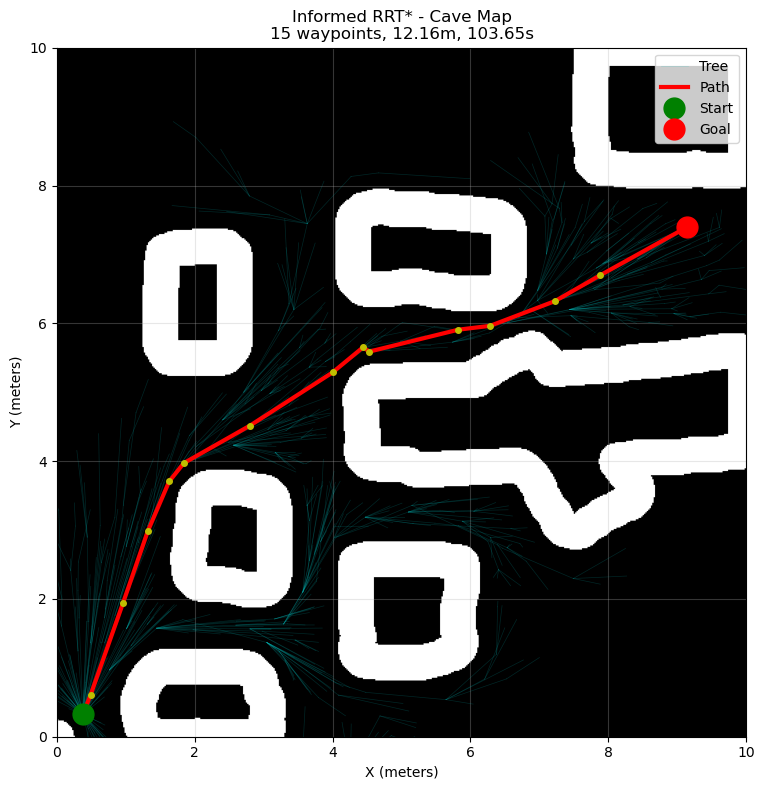

In [24]:
if path_map_2:
    fig, ax = plt.subplots(figsize=(12, 8))

    # Show map
    ax.imshow(mapa_2, cmap='gray', origin='lower',
             extent=[0, terrain_width_2, 0, terrain_height_2])

    # Draw tree edges
    for node in planner_2.nodes:
        if node.parent:
            ax.plot([node.x, node.parent.x], [node.y, node.parent.y],
                   'c-', alpha=0.2, linewidth=0.5, label='Tree' if node == planner_2.nodes[1] else '')

    # Draw path
    path_x = [p[0] for p in path_map_2]
    path_y = [p[1] for p in path_map_2]
    ax.plot(path_x, path_y, 'r-', linewidth=3, label='Path')
    ax.plot(path_x, path_y, 'yo', markersize=4)

    # Mark start and goal
    ax.plot(start_map_2[0], start_map_2[1], 'go', markersize=15, label='Start')
    ax.plot(goal_map_2[0], goal_map_2[1], 'ro', markersize=15, label='Goal')

    ax.set_xlim(0, terrain_width_2)
    ax.set_ylim(0, terrain_height_2)
    ax.set_xlabel('X (meters)')
    ax.set_ylabel('Y (meters)')
    ax.set_title(f'Informed RRT* - Cave Map\n{len(path_map_2)} waypoints, {path_length_2:.2f}m, {elapsed_time_2:.2f}s')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 16. Execute Path in Cave Scene

In [25]:
if path_map_2:
    # Convert to CoppeliaSim coordinates
    path_sim_2 = [map_to_sim_cave(x, y) for x, y in path_map_2]

    print(f"   Total waypoints: {len(path_sim_2)}")
    print(f"   Path length: {path_length_2:.2f} m")
    print(f"   Speed: {ROBOT_SPEED}")
    print(f"   Position tolerance: {POSITION_THRESHOLD} m")
    print(f"   Using holonomic proportional control (no forced orientation)")

    # Start simulation
    controller.start_simulation()
    time.sleep(0.5)

    try:
        # Execute path
        success = controller.move_along_path(
            path_sim_2,
            speed=ROBOT_SPEED,
            tolerance=POSITION_THRESHOLD,
            visualize=True
        )

        if success:
            final_x, final_y, final_theta = controller.get_robot_pose_2d()
            final_error = np.sqrt((final_x - goal_pos_2[0])**2 + (final_y - goal_pos_2[1])**2)

            print(f"   Final position: ({final_x:.2f}, {final_y:.2f})")
            print(f"   Final orientation: {np.degrees(final_theta):.1f}°")
            print(f"   Final error: {final_error:.3f} m")
        else:
            print(f"\nPath execution failed!")

    except Exception as e:
        print(f"\nError during execution: {e}")

    finally:
        # Stop simulation
        controller.stop_simulation()
        print("\n✓ Simulation stopped")

   Total waypoints: 15
   Path length: 12.16 m
   Speed: 0.5
   Position tolerance: 0.15 m
   Using holonomic proportional control (no forced orientation)

🚀 Starting path following (15 waypoints)...
   Using holonomic proportional control
  → Waypoint 1/15: (-4.63, -4.67)
    ✓ Waypoint 1 (error: 0.000m, theta: 0.0°)
  → Waypoint 2/15: (-4.51, -4.39)
    ✓ Waypoint 2 (error: 0.146m, theta: 0.4°)
  → Waypoint 3/15: (-4.04, -3.06)
    ✓ Waypoint 3 (error: 0.148m, theta: 3.7°)
  → Waypoint 4/15: (-3.68, -2.01)
    ✓ Waypoint 4 (error: 0.142m, theta: 6.0°)
  → Waypoint 5/15: (-3.37, -1.30)
    ✓ Waypoint 5 (error: 0.142m, theta: 5.5°)
  → Waypoint 6/15: (-3.16, -1.03)
    ✓ Waypoint 6 (error: 0.145m, theta: 5.9°)
  → Waypoint 7/15: (-2.20, -0.48)
    ✓ Waypoint 7 (error: 0.144m, theta: 3.8°)
  → Waypoint 8/15: (-1.00, 0.29)
    ✓ Waypoint 8 (error: 0.144m, theta: -2.9°)
  → Waypoint 9/15: (-0.56, 0.65)
    ✓ Waypoint 9 (error: 0.144m, theta: -3.1°)
  → Waypoint 10/15: (-0.47, 0.59)
    ✓ 

---

## 17. Cleanup

In [26]:
# Disconnect
controller.disconnect()
print("✓ Disconnected from CoppeliaSim")


Disconnecting from CoppeliaSim...
✓ Disconnected from CoppeliaSim


---


This implementation demonstrates:

1. ✅ **Informed RRT*** path planning in 2D environments
2. ✅ **Holonomic robot control** (Robotino with 3 omnidirectional wheels)
3. ✅ **Ellipsoidal informed sampling** for faster convergence
4. ✅ **Asymptotic optimality** through continuous rewiring
5. ✅ **Tree visualization** showing exploration vs exploitation
6. ✅ **Two successful experiments** with different map complexities

### Algorithm Characteristics:

#### Informed RRT* Features:
- **Completeness**: Probabilistically complete
- **Optimality**: Asymptotically optimal (converges to optimal solution)
- **Informed Sampling**: Focuses on promising regions after finding initial solution
- **Rewiring**: Continuously improves tree structure
- **Adaptability**: Works in both cluttered and open environments

### Comparison with PRM (Roadmap):

| Aspect | Informed RRT* | PRM (Roadmap) |
|--------|---------------|---------------|
| **Exploration** | Tree-based, focused | Graph-based, uniform |
| **Optimality** | Asymptotically optimal | Sub-optimal (depends on sampling) |
| **Adaptability** | Single query efficient | Multiple queries efficient |
| **Memory** | Tree structure | Full graph |
| **Convergence** | Informed sampling speeds up | Uniform sampling throughout |

### Key Improvements:
- **Ellipsoidal Heuristic**: Restricts sampling to region that can improve solution
- **Cost-based Rewiring**: Continuously optimizes path during search
- **Goal Biasing**: Balances exploration and exploitation
- **Anytime Algorithm**: Can provide solution at any time with improving quality

### References:
1. **Gammell et al. (2014)**: "Informed RRT*: Optimal Sampling-based Path Planning"
2. **Karaman & Frazzoli (2011)**: "Sampling-based Algorithms for Optimal Motion Planning"
3. **Course Materials**: Aula 14 - Planejamento de Caminhos (PRM e RRT)
